In [52]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

file_path = "C:/Users/yejin/Downloads/market-price.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# DataFrame 생성
df = pd.DataFrame(data)

# 'market-price' 컬럼에서 'x', 'y' 추출
df['day'] = df['market-price'].apply(lambda d: datetime.fromtimestamp(d['x'] / 1000))
df['price'] = df['market-price'].apply(lambda d: d['y'])

# 필요한 열만 선택
bitcoin_df = df[['day', 'price']]

# 확인
print(bitcoin_df.head())

                  day     price
0 2024-07-12 09:00:00  57351.64
1 2024-07-13 09:00:00  57907.93
2 2024-07-14 09:00:00  59231.12
3 2024-07-15 09:00:00  60798.16
4 2024-07-16 09:00:00  64859.79


C:\Users\yejin\AppData\Local\Temp\ipykernel_26328\3134679900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) # 시계열 피처로 변환


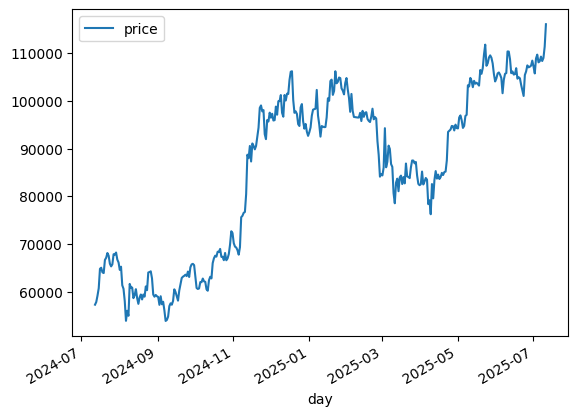

In [53]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) # 시계열 피처로 변환

# 시계열 데이터 인덱스로 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

# 시각화
bitcoin_df.plot()
plt.show()

In [54]:
# 데이터 분할

train_df = bitcoin_df[:-5]
test_df = bitcoin_df[-5:]

In [55]:
from statsmodels.tsa.arima.model import ARIMA  # 최신 모듈
import statsmodels.api as sm

# ARIMA 모델 생성 및 학습
model = ARIMA(train_df['price'], order=(2,1,2))
model_fit = model.fit()

# 결과 출력
print(model_fit.summary())

C:\Users\yejin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yejin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yejin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3259.045
Date:                Fri, 11 Jul 2025   AIC                           6528.089
Time:                        23:13:29   BIC                           6547.506
Sample:                    07-12-2024   HQIC                          6535.811
                         - 07-06-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3192      0.796      0.401      0.688      -1.240       1.878
ar.L2          0.5035      0.801      0.628      0.530      -1.067       2.074
ma.L1         -0.3344      0.810     -0.413      0.6

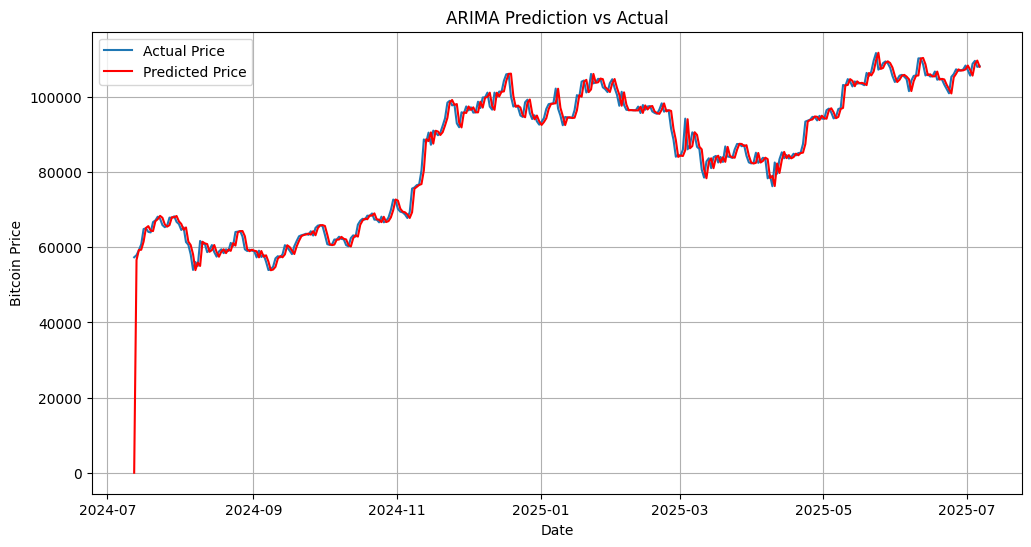

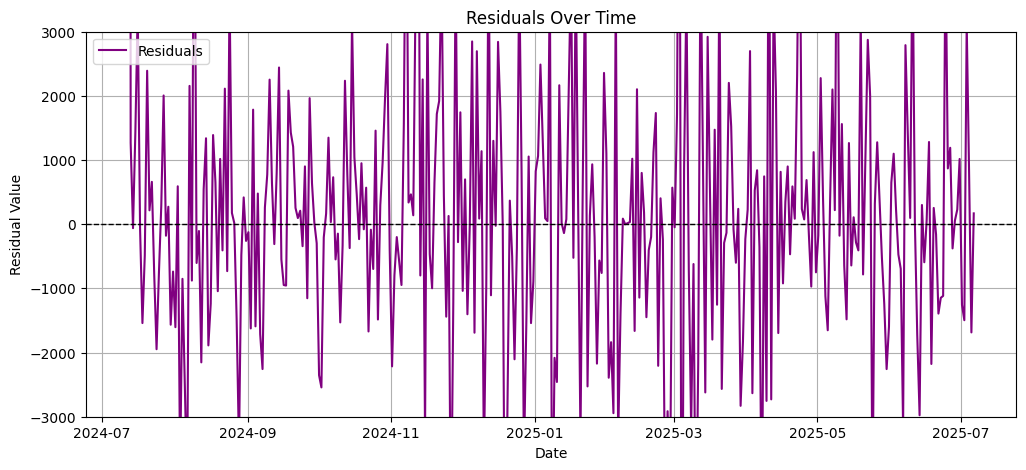

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측 결과 시각화
start = 0
end = len(train_df) - 1
pred = model_fit.predict(start=start, end=end)

plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['price'], label='Actual Price')
plt.plot(train_df.index[start:end+1], pred, label='Predicted Price', color='red')
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("ARIMA Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# 잔차 (residuals)
residuals_series = pd.Series(model_fit.resid, index=train_df.index)

# 시계열 잔차 그래프
plt.figure(figsize=(12,5))
plt.plot(residuals_series, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # 기준선
plt.ylim(-3000, 3000)  # y축 범위 설정
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.grid(True)
plt.legend()
plt.show()


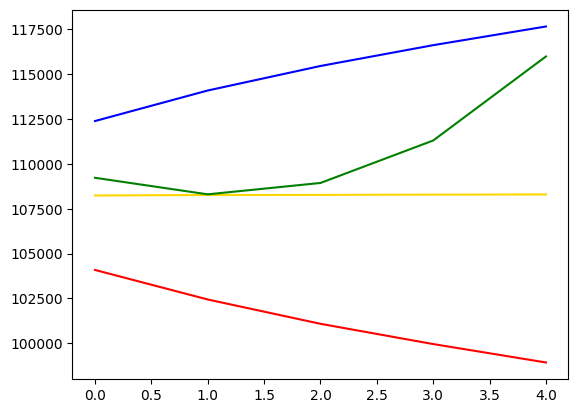

In [95]:
# 실제 데이터와의 비교
forecast_data = model_fit.get_forecast(steps=5)

# 예측값 (Series 형태)
pred_y = forecast_data.predicted_mean.tolist()

# 신뢰구간
conf_int = forecast_data.conf_int()  # DataFrame 형태
pred_y_lower = []
pred_y_upper = []

for lower_upper in conf_int.iterrows():
    lower = lower_upper[1]['lower price']
    upper = lower_upper[1]['upper price']
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

plt.plot(pred_y, color = 'gold') # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color='blue') # 모델이 예측한 최고 가격 그래프
plt.plot(test_y, color='green') # 실제 가격 그래프

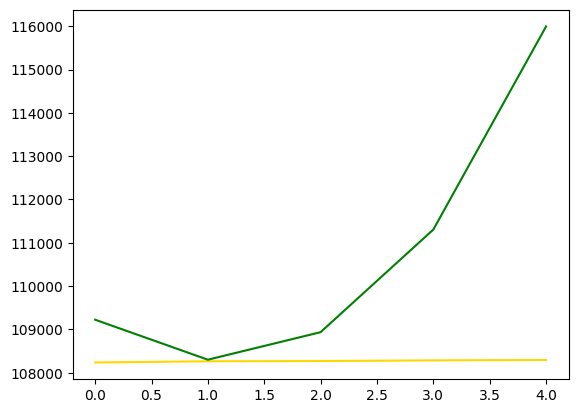

In [97]:
# 실제 가격 vs 예측 가격
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')